In [1]:
import numpy as np
import h5py as h5
import os
import sys
import emcee as em
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import pickle

from JetFit import FitterClass

% matplotlib inline

# Parameters

In [2]:
Table = "./Table.h5" 

Info = {
    'Fit': np.array(['theta_obs']),  # Fitting parameters
    'Log': np.array(['E','n','epse','epsb']),        # Set parameters in log scale
    'LogType': 'Log10',                              # Log scale type: Log10 or Log
    'ThetaObsPrior': 'Sine',                         # Prior for observation angle: Sine or Uniform
    'FluxType': 'Spectral'                           # Flux type: Spectral or Integrated
}

### Bounds for parameters. All in linear scale. 
FitBound = {
    'E': np.array([1e-6, 1e3]),
    'n': np.array([1e-6, 1e3]),
    'Eta0': np.array([2.,10.]),
    'GammaB': np.array([1.,12.]),
    'theta_obs': np.array([0.,1.]),
    'epse': np.array([1e-6,1.]),
    'epsb': np.array([1e-6,1.]),
    'p': np.array([2.,4.])
}



### P serves two purposes: 
###    1. Set default values for non-fiting parameters.
###    2. In formal run, set maximum posterior values for fitting parameters. (In trial run, values are ignored.)
       
P = {
    'E': 0.15869069395227384,
    'Eta0': 7.973477192135503,
    'GammaB': 11.000923300022666,
    'dL': 0.012188,
    'epsb': 0.013323706571267526,
    'epse': 0.04072783842837688,
    'n': 0.0009871221028954489,
    'p': 2.1333493591554804,
    'theta_obs': 0.4769798916899842,
    'xiN': 1.0,
    'z': 0.00973
}

Trial = True

In [3]:
# Path to observation data. 
GRB = './GW170817.csv'

### parameters for fitter. 
# for demostaration
SamplerType = "ParallelTempered"
NTemps = 2          
NWalkers = 10      
Threads = 8        

BurnLength = 20     
RunLength = 20     

### For GW170817 and bellow parameters, it takes ~24 hours to finish. 
### For quick run, values of the parameters can be modified accordingly. 
# SamplerType = "ParallelTempered"
# NTemps = 10          
# NWalkers = 100      
# Threads = 8        

# BurnLength = 10000     
# RunLength = 10000  

# Fitter 

In [4]:
# Initialize Fitter
Fitter = FitterClass(Table, Info, FitBound, P, Trial = Trial)

# LoadData
DF = pd.read_csv(GRB)
Times, TimeBnds, Fluxes, FluxErrs, Freqs = DF['Times'].values, DF['TimeBnds'].values, DF['Fluxes'].values, DF['FluxErrs'].values, DF['Freqs'].values
Fitter.LoadData(Times, TimeBnds, Fluxes, FluxErrs, Freqs)

# Initialize sampler
Fitter.GetSampler(SamplerType, NTemps, NWalkers, Threads)

# Fitting

In [5]:
### Burning in

BurnInResult = Fitter.BurnIn(BurnLength = BurnLength)

 Burning in... 100.0% Time=00 m 41 s

In [6]:
### Fitting

Result = Fitter.RunSampler(RunLength = RunLength, Output = None)

 Running... 100.0% Time=00 m 41 s

# Analysis

### Plot Light Curves

In [7]:
def Log2Linear(Log, Info):
    Linear = []
    for i, key in enumerate(Info['Fit']):
        if key in Info['Log']:
            if Info['LogType'] == 'Log10':
                Linear.append(np.power(10.,Log[i]))
            else:
                Linear.append(np.exp(Log[i]))
        else:
            Linear.append(Log[i])
    return np.array(Linear)

def PltDF(ax, DF, ColorList=['orange','red','g','b'], ScaleFactor=[1.,1.,1.,1.], Legend=True, XAxisDay=False):
    Freqs = DF['Freqs'].unique()

    for Freq,Color,Scale in zip(Freqs,ColorList,ScaleFactor):
        SubDF = DF[DF['Freqs']==Freq]
        if XAxisDay:
            Times = SubDF['Times']/24./3600
        else:
            Times = SubDF['Times']
        Fluxes = SubDF['Fluxes']
        FluxErrs = SubDF['FluxErrs']
        if max(ScaleFactor) > 1.:
            label = '%.1e x %d' %(Freq, Scale)
        else:
            label='%.1e' %Freq
        ax.errorbar(Times, Fluxes*Scale, yerr = FluxErrs*Scale, color=Color, fmt = '.', label=label)

    ax.set_yscale('log')                                                                              
    ax.set_xscale('log')     
    ax.set_ylabel('Flux density (mJy)')     
    if XAxisDay:
        ax.set_xlabel('Time (day)') 
    else:
        ax.set_xlabel('Time (s)') 
    if Legend: 
        ax.legend(loc=0);

In [8]:
TheChain = Result['Chain']
LnProbability = Result['LnProbability']
FitDim = len(Info['Fit'])

BestWalker = np.unravel_index(np.nanargmax(LnProbability), LnProbability.shape)
BestParameter = TheChain[BestWalker]
BestLnProbability = LnProbability[BestWalker]
BestLinearParameter = Log2Linear(BestParameter, Info)

BestP = P.copy()
for i, key in enumerate(Info['Fit']):
    BestP[key] = BestLinearParameter[i]
    

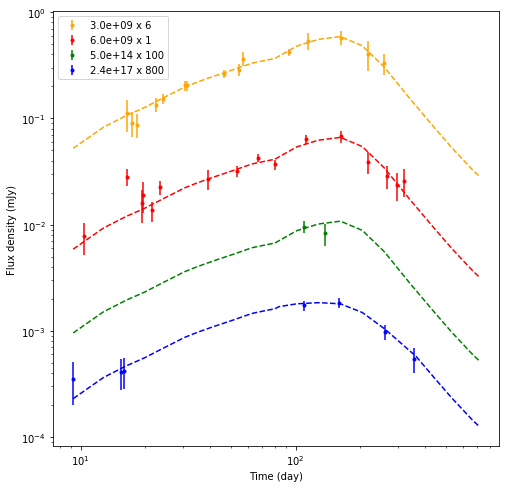

In [9]:
fig, ax = plt.subplots(figsize=(8,8));
ColorList = ['orange','red','g','b']
ScaleFactor =  [6.,1.,100., 800.]

PltDF(ax, DF, ColorList=ColorList, ScaleFactor=ScaleFactor, Legend=True, XAxisDay=True)

NPoints = 200
Left = 1.; Right = 2.
for i, Freq in enumerate(DF['Freqs'].unique()):
    idx = DF['Freqs']==Freq    
    NewTimes = np.linspace(DF['Times'].min()*Left, DF['Times'].max()*Right, NPoints)
    NewFreqs = np.ones(len(NewTimes))*Freq
    
    ### Generate Fluxes 
    FluxesModel = np.asarray(Fitter.FluxGenerator.GetSpectral(NewTimes, NewFreqs, BestP))
    
    plt.loglog(NewTimes/24./3600., FluxesModel*ScaleFactor[i], '--', color=ColorList[i], linewidth=1.5);

### Plot Distribution

In [10]:
Info['Fit']

Latex = {
    'E': r'$log_{10}E_{j,50}$',
    'n': r'$log_{10}n_{0,0}$',
    'Eta0': r'$\eta_0$',
    'GammaB': r'$\gamma_B$',
    'theta_obs': r'$\theta_{obs}$',
    'epse': r'$log_{10}\epsilon_e$',
    'epsb': r'$log_{10}\epsilon_B$',
    'p': r'$p$'
}

Label = []
for x in Info['Fit']:
    Label.append(Latex[x])

In [11]:
from chainconsumer import ChainConsumer

FitDim = len(Info['Fit'])
Chain = Result['Chain'].reshape((-1, FitDim))

Label = Label

c = ChainConsumer().add_chain(Chain, walkers=100, parameters=Label, name="Median")
c.configure(spacing=1, bins=1., smooth=0, sigmas=[0,0.25,1,2,3], colors='b')
c.configure_truth(color='blue', ls="--", alpha=0.5);

In [12]:
Median = {}
Summary = c.analysis.get_summary()
for key in Label:
    Median[key] = Summary[key][1]
    
MedianParameter = []
for i, key in enumerate(Info['Fit']):
    MedianParameter.append(Summary[Label[i]][1])

MedianLinearParameter = Log2Linear(MedianParameter, Info)
MedianP = P.copy()
for i, key in enumerate(Info['Fit']):
    MedianP[key] = MedianLinearParameter[i]
    
df = (pd.DataFrame(MedianLinearParameter, index=Info['Fit'], columns=['Median'])).T
df.loc['Best'] = BestLinearParameter
df

,theta_obs
Median,0.476672
Best,0.477463


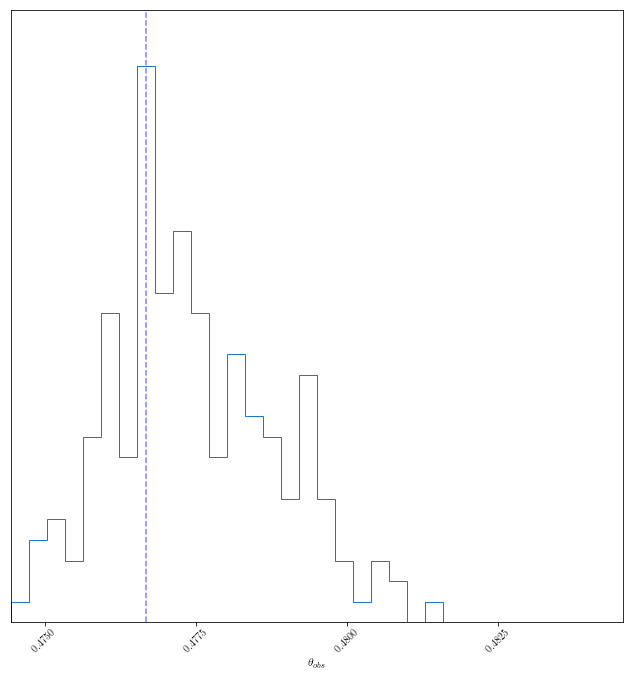

In [13]:
fig = c.plotter.plot(figsize='PAGE',truth=Median)